In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

2024-08-22 15:57:13.992305: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 15:57:14.033853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]


In [3]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [4]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

In [7]:
# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)


In [8]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240731/'

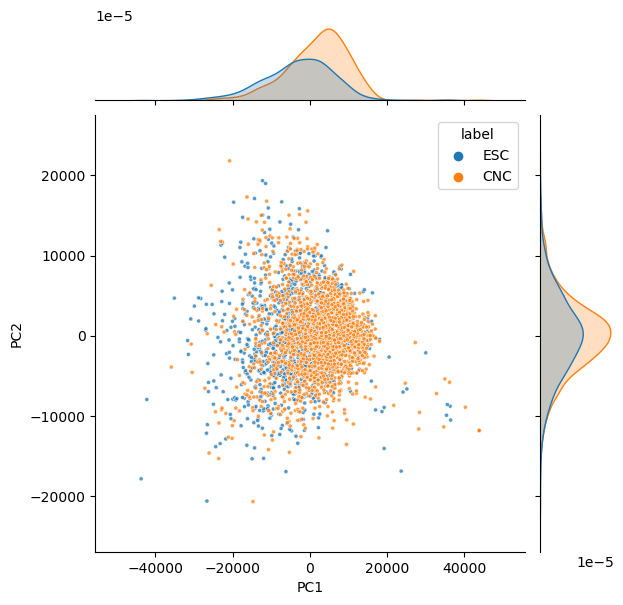

In [9]:
sns.jointplot(x='PC1', y='PC2', data=all_df, marker='.', hue='label', alpha=0.75)
plt.savefig(save_dir + 'pca_2d.png', dpi=300, bbox_inches='tight')

In [10]:
# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
pc1_05 = all_df['PC1'].quantile(0.05)
pc1_95 = all_df['PC1'].quantile(0.95)
pc2_05 = all_df['PC2'].quantile(0.05)
pc2_95 = all_df['PC2'].quantile(0.95)

In [11]:
pc1_95

12412.170592413495

In [12]:
pc1_grid = np.linspace(pc1_05, pc1_95, 10)
pc2_grid = np.linspace(pc2_05, pc2_95, 10)

In [13]:
# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

In [14]:
# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

In [15]:
all_meta_df = pd.concat([all_df, pc1_pc2_df], axis=0)

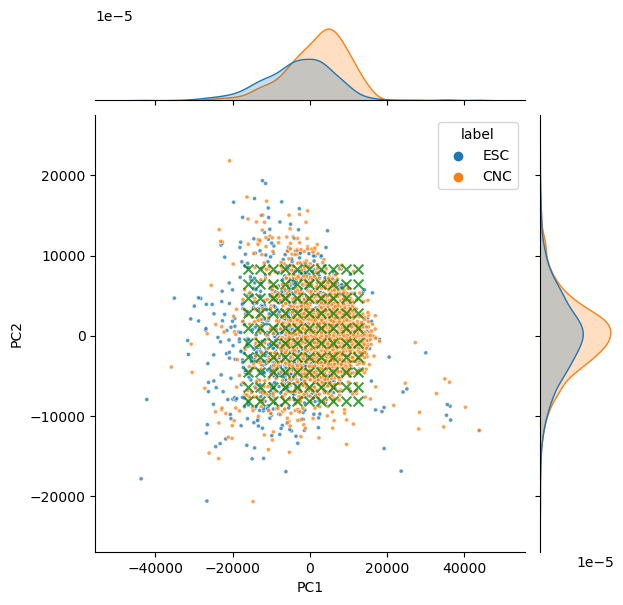

In [16]:
sns.jointplot(x='PC1', y='PC2', data=all_df, marker='.', hue='label', alpha=0.75)
plt.scatter(pc1_grid_flat, pc2_grid_flat, marker='x', color='green', s=50, alpha=0.75)
plt.savefig(save_dir + 'pca_2d_with_metastructure.png', dpi=300, bbox_inches='tight')

In [17]:
# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)

In [18]:
pc1_pc2_df

PC1          PC2           label
0  -15946.131406  8321.504054  metastructures
1  -15946.131406  6488.137481  metastructures
2  -15946.131406  4654.770907  metastructures
3  -15946.131406  2821.404334  metastructures
4  -15946.131406   988.037760  metastructures
..           ...          ...             ...
95  12412.170592  -845.328813  metastructures
96  12412.170592 -2678.695387  metastructures
97  12412.170592 -4512.061960  metastructures
98  12412.170592 -6345.428534  metastructures
99  12412.170592 -8178.795107  metastructures

[100 rows x 3 columns]

In [19]:
pc1_pc2_df['PC1'].values

array([-15946.13140634, -15946.13140634, -15946.13140634, -15946.13140634,
       -15946.13140634, -15946.13140634, -15946.13140634, -15946.13140634,
       -15946.13140634, -15946.13140634, -12795.20896203, -12795.20896203,
       -12795.20896203, -12795.20896203, -12795.20896203, -12795.20896203,
       -12795.20896203, -12795.20896203, -12795.20896203, -12795.20896203,
        -9644.28651773,  -9644.28651773,  -9644.28651773,  -9644.28651773,
        -9644.28651773,  -9644.28651773,  -9644.28651773,  -9644.28651773,
        -9644.28651773,  -9644.28651773,  -6493.36407342,  -6493.36407342,
        -6493.36407342,  -6493.36407342,  -6493.36407342,  -6493.36407342,
        -6493.36407342,  -6493.36407342,  -6493.36407342,  -6493.36407342,
        -3342.44162912,  -3342.44162912,  -3342.44162912,  -3342.44162912,
        -3342.44162912,  -3342.44162912,  -3342.44162912,  -3342.44162912,
        -3342.44162912,  -3342.44162912,   -191.51918481,   -191.51918481,
         -191.51918481,  

In [20]:
pc1_pc2_df['PC1'].unique()

array([-15946.13140634, -12795.20896203,  -9644.28651773,  -6493.36407342,
        -3342.44162912,   -191.51918481,   2959.4032595 ,   6110.3257038 ,
         9261.24814811,  12412.17059241])

In [21]:
pc1_pc2_df['PC2'].values

array([ 8321.50405419,  6488.13748072,  4654.77090725,  2821.40433378,
         988.0377603 ,  -845.32881317, -2678.69538664, -4512.06196011,
       -6345.42853359, -8178.79510706,  8321.50405419,  6488.13748072,
        4654.77090725,  2821.40433378,   988.0377603 ,  -845.32881317,
       -2678.69538664, -4512.06196011, -6345.42853359, -8178.79510706,
        8321.50405419,  6488.13748072,  4654.77090725,  2821.40433378,
         988.0377603 ,  -845.32881317, -2678.69538664, -4512.06196011,
       -6345.42853359, -8178.79510706,  8321.50405419,  6488.13748072,
        4654.77090725,  2821.40433378,   988.0377603 ,  -845.32881317,
       -2678.69538664, -4512.06196011, -6345.42853359, -8178.79510706,
        8321.50405419,  6488.13748072,  4654.77090725,  2821.40433378,
         988.0377603 ,  -845.32881317, -2678.69538664, -4512.06196011,
       -6345.42853359, -8178.79510706,  8321.50405419,  6488.13748072,
        4654.77090725,  2821.40433378,   988.0377603 ,  -845.32881317,
      

In [22]:
metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])

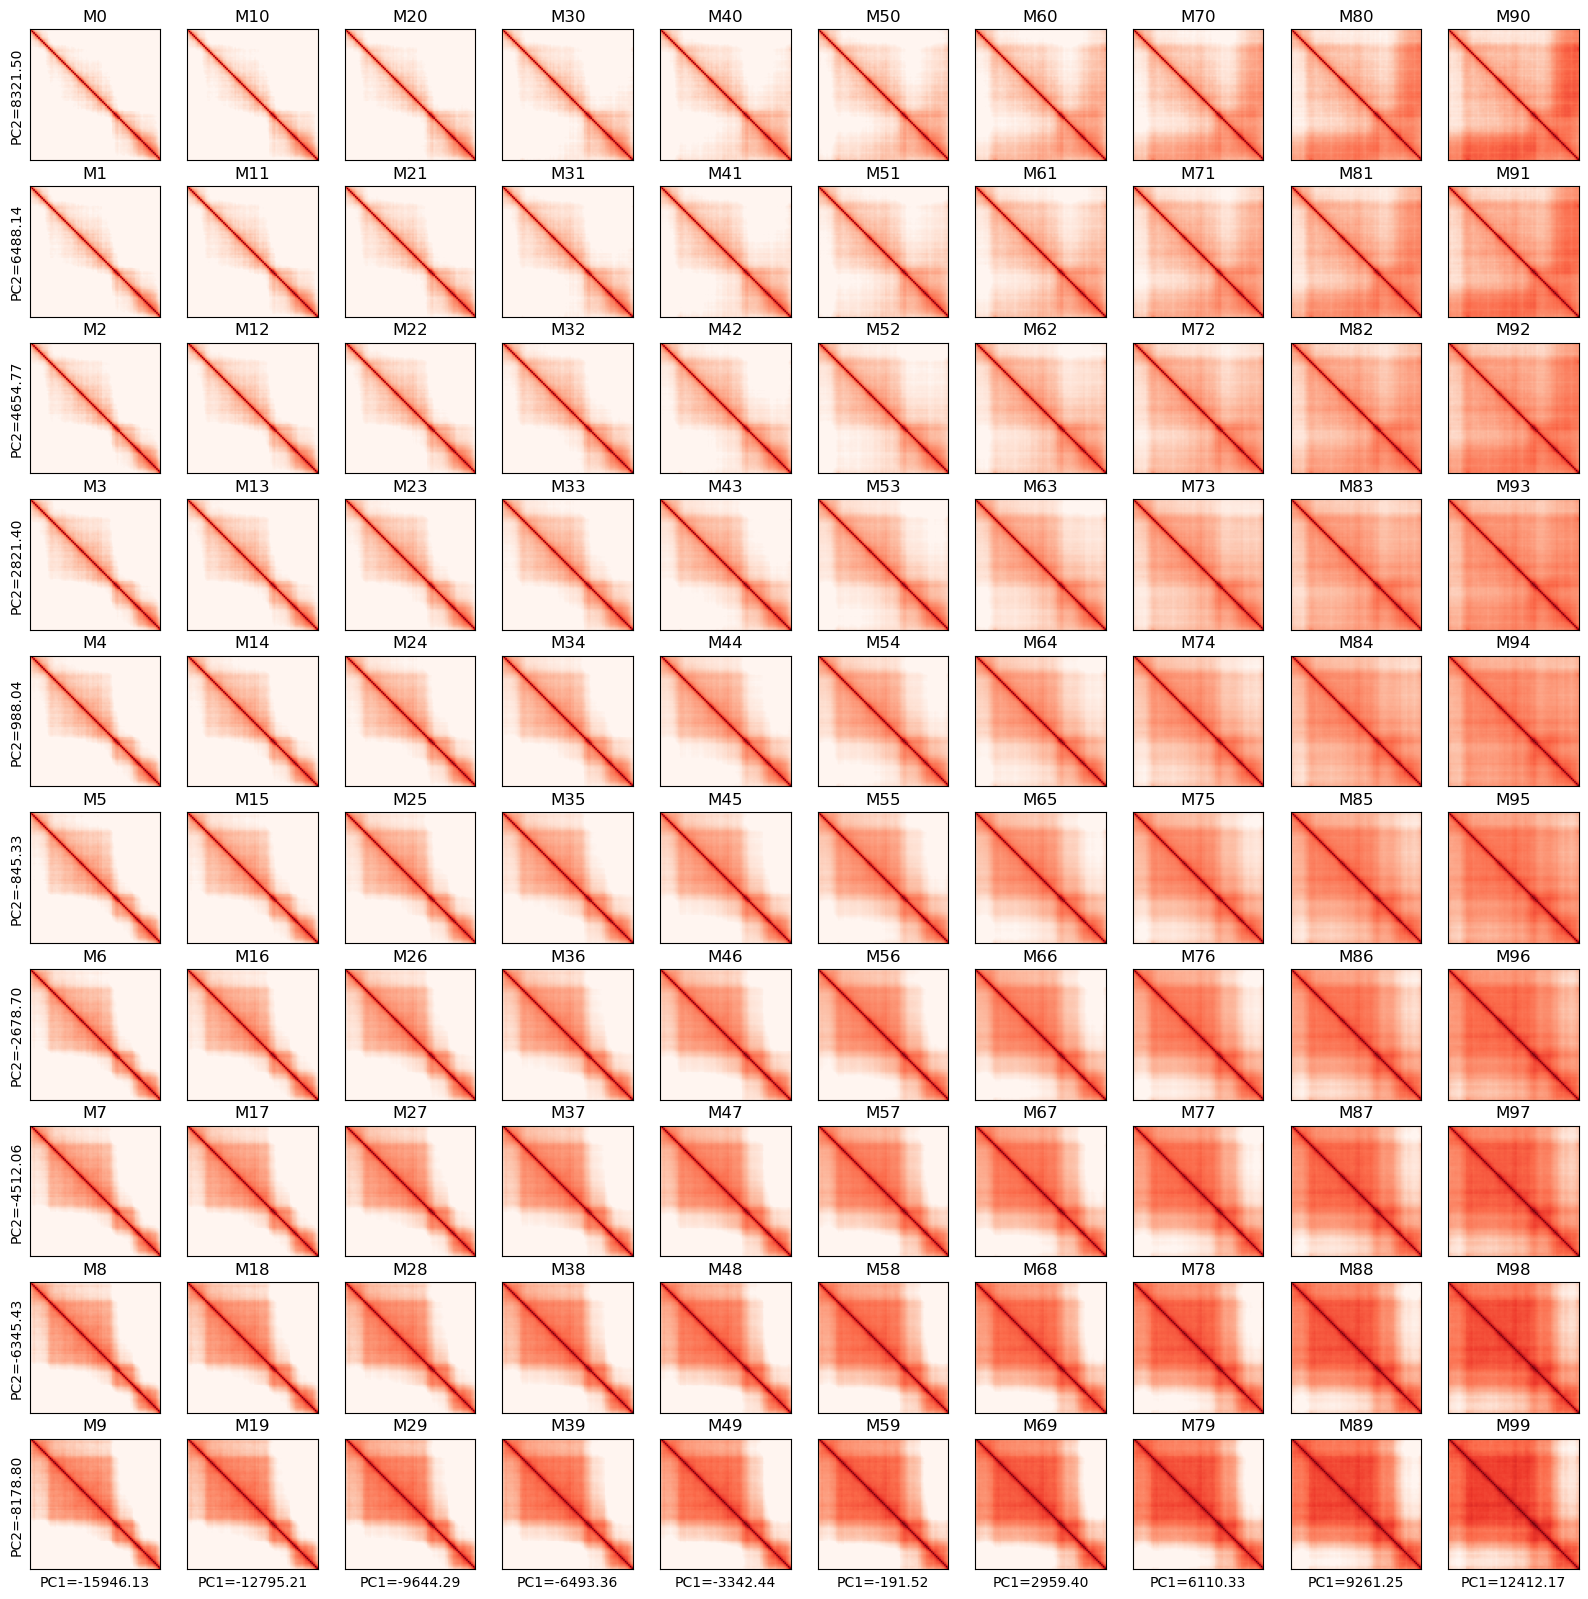

In [23]:
# Plot 10 x 10 grid of metastructures based on PC1 and PC2 
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax = ax=axs[i%10, i//10]
    metastr = metastr_from_pca[i]
    metastr = metastr.reshape((80, 80))
    ax.imshow(metastr, cmap='Reds_r', vmax=700)
    ax.set_title(f'M{i}')
    # axs[i//10, i%10].axis('off')
    # if ax is in the first col, add a y label
    if i // 10 == 0:
        ax.set_ylabel(f'PC2={pc1_pc2_df.iloc[i, 1]:.2f}')
    # if ax is in the last row, add a x label
    if i % 10 == 9:
        ax.set_xlabel(f'PC1={pc1_pc2_df.iloc[i, 0]:.2f}')
        
    # Remove ticks by setting them to an empty list
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig(save_dir + 'metastructure_maps_sorted_by_pca.png', dpi=300, bbox_inches='tight')

In [24]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

In [25]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240801_WeightMCMC_PCA_metastructures/'

In [26]:
stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_cnc = os.path.join(common_dir, 'CNC/stan_output')
stan_directory_all = os.path.join(common_dir, 'all/stan_output')


In [27]:
esc_log_weights = load_weights(stan_directory_esc, 100)
cnc_log_weights = load_weights(stan_directory_cnc, 100)
all_log_weights = load_weights(stan_directory_all, 100)

['20240715_WeightOptimization-20240801102525_1.csv', '20240715_WeightOptimization-20240801102525_2.csv', '20240715_WeightOptimization-20240801102525_3.csv', '20240715_WeightOptimization-20240801102525_4.csv']
['20240715_WeightOptimization-20240801102542_1.csv', '20240715_WeightOptimization-20240801102542_2.csv', '20240715_WeightOptimization-20240801102542_3.csv', '20240715_WeightOptimization-20240801102542_4.csv']
['20240715_WeightOptimization-20240801102600_1.csv', '20240715_WeightOptimization-20240801102600_2.csv', '20240715_WeightOptimization-20240801102600_3.csv', '20240715_WeightOptimization-20240801102600_4.csv']


In [28]:
esc_weights = np.mean(np.exp(np.array(esc_log_weights)), axis=(0, 1))
cnc_weights = np.mean(np.exp(np.array(cnc_log_weights)), axis=(0, 1))

In [29]:
np.sum(esc_weights[:20])/np.sum(esc_weights)

0.2289672341221478

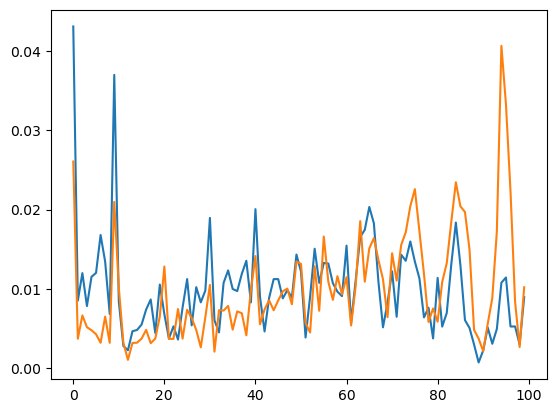

In [30]:
plt.plot(esc_weights)
plt.plot(cnc_weights)

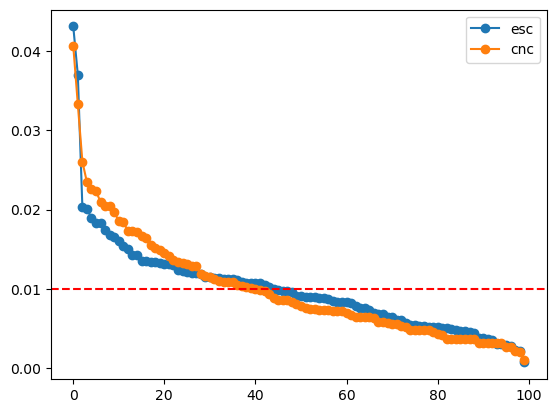

In [31]:
plt.plot(np.sort(esc_weights)[::-1], 'o-', label='esc')
plt.plot(np.sort(cnc_weights)[::-1], 'o-', label='cnc')
plt.axhline(y=0.01, color='r', linestyle='--')
plt.legend()
plt.savefig(os.path.join(save_dir, 'sort_weights.png'), dpi=300, bbox_inches='tight')

In [32]:
# Put weights in a DataFrame
esc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values,  
                               'weight': esc_weights})
esc_weights_df['label'] = 'ESC'
cnc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values, 
                               'weight': cnc_weights})
cnc_weights_df['label'] = 'CNC'

In [33]:
import matplotlib

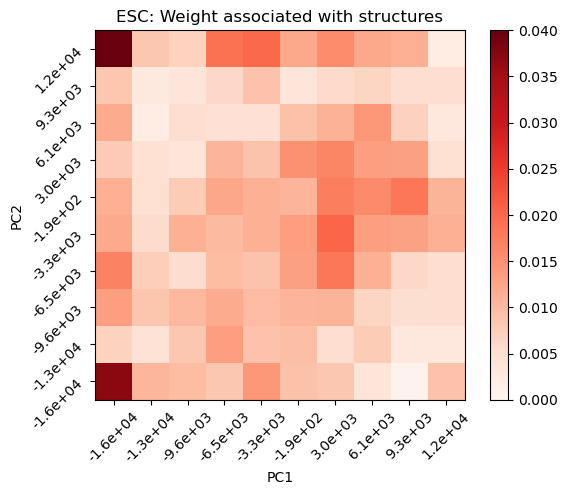

In [34]:
plt.imshow(esc_weights_df['weight'].values.reshape(10, 10).T,
           cmap='Reds', vmin=0, vmax=0.04)
# set xticks 
plt.xticks(np.arange(10), [f"{x:.1e}" for x in esc_weights_df['PC1'].unique()], rotation=45)
plt.yticks(np.arange(10), [f"{x:.1e}" for x in esc_weights_df['PC2'].unique()][::-1], rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC: Weight associated with structures')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'esc_weights_10x10.png'), dpi=300, bbox_inches='tight')

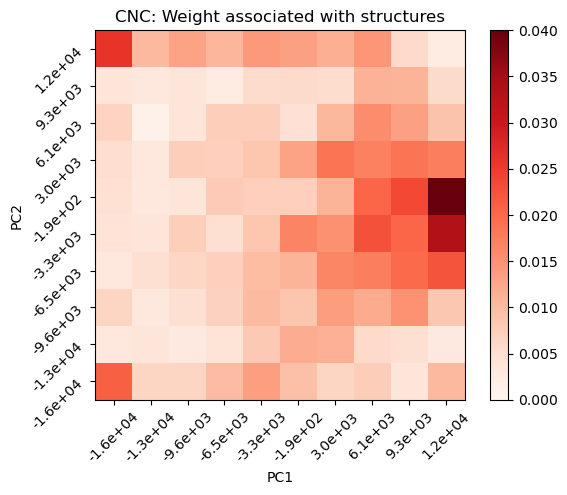

In [35]:
plt.imshow(cnc_weights_df['weight'].values.reshape(10, 10).T,
           cmap='Reds', vmin=0, vmax=0.04)
# set xticks 
plt.xticks(np.arange(10), [f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()], rotation=45)
plt.yticks(np.arange(10), [f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()][::-1], rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC: Weight associated with structures')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'cnc_weights_10x10.png'), dpi=300, bbox_inches='tight')

In [36]:
esc_weights_grid = esc_weights_df['weight'].values.reshape(10, 10).T
cnc_weights_grid = cnc_weights_df['weight'].values.reshape(10, 10).T

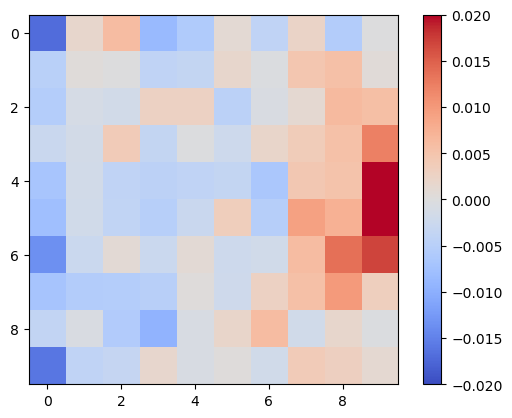

In [37]:
plt.imshow(cnc_weights_grid - esc_weights_grid, cmap='coolwarm', vmin=-0.02, vmax=0.02)
plt.colorbar()

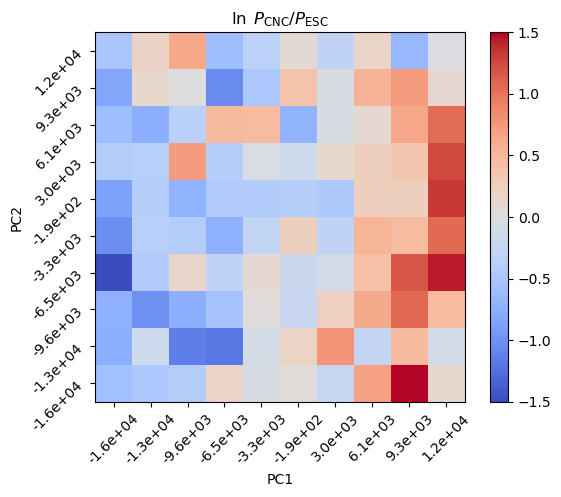

In [38]:
plt.imshow(np.log(cnc_weights_grid / esc_weights_grid), cmap='coolwarm', vmin=-3/2, vmax=3/2)
plt.colorbar()
plt.xticks(np.arange(10), [f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()], rotation=45)
plt.yticks(np.arange(10), [f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()][::-1], rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; P_\mathrm{CNC}/P_\mathrm{ESC}$')
plt.savefig(os.path.join(save_dir, 'prob_ratio.png'), dpi=300, bbox_inches='tight')

In [39]:
diff_table = np.log(cnc_weights_grid / esc_weights_grid)

In [40]:
metastr_dict = {}
for i in range(100):
    idx = (i%10, i//10)
    metastr = metastr_from_pca[i]
    metastr = metastr.reshape((80, 80))
    metastr_dict[idx] = metastr

In [44]:
diff_table[np.unravel_index(np.argsort(diff_table, axis=None), diff_table.shape)]

array([-1.64726832, -1.17710592, -1.13951809, -1.05102149, -1.02587591,
       -1.00513543, -0.87394517, -0.8252447 , -0.75258692, -0.7462456 ,
       -0.74571162, -0.72239718, -0.71642731, -0.71302529, -0.69386513,
       -0.66061209, -0.58931783, -0.58578012, -0.56667329, -0.53749511,
       -0.50241605, -0.482416  , -0.4800567 , -0.46837594, -0.44928959,
       -0.42905494, -0.42339747, -0.41986112, -0.41640596, -0.41240383,
       -0.40074885, -0.39379524, -0.39056402, -0.38515978, -0.3779621 ,
       -0.35394635, -0.34824917, -0.30391816, -0.2966694 , -0.29617389,
       -0.27312038, -0.26760401, -0.24913519, -0.21708903, -0.19038875,
       -0.17300833, -0.15806472, -0.11729423, -0.10797547, -0.10134612,
       -0.0676808 , -0.06581489, -0.06325684, -0.03558167, -0.03273564,
       -0.01055311,  0.02050386,  0.0249792 ,  0.07644342,  0.08242703,
        0.08897315,  0.09569035,  0.11446883,  0.13011739,  0.13263859,
        0.15582914,  0.17006683,  0.17261242,  0.18314061,  0.18

In [45]:
# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[-10:]

# Convert the flattened indices back to 2D indices
top_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
top_10_indices = list(zip(top_10_indices[0], top_10_indices[1]))

In [48]:
diff_table[np.unravel_index(flattened_indices, diff_table.shape)][-1]

1.6010722371104273

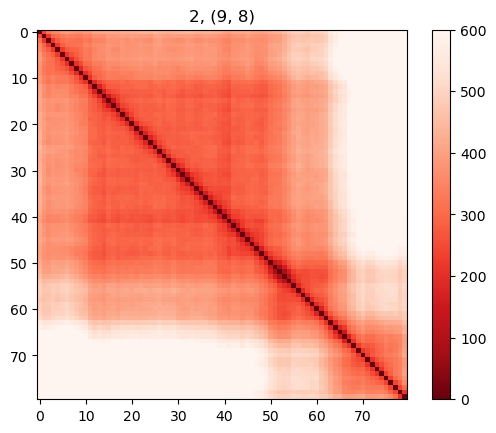

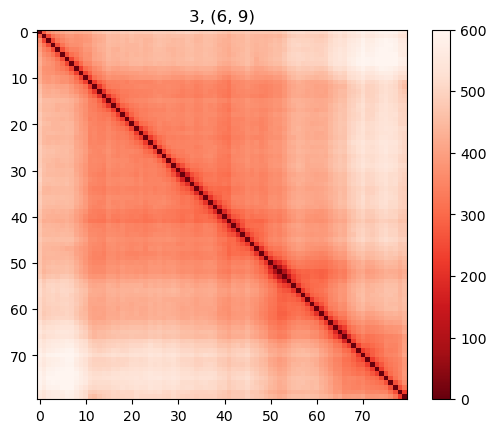

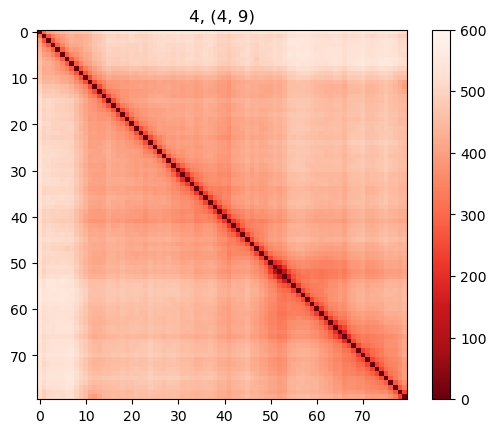

In [49]:
for i in range(1, 4):
    plt.imshow(metastr_dict[top_10_indices[-i]], cmap='Reds_r', vmax=600)
    plt.colorbar()
    plt.title('{}, {}'.format(i+1, top_10_indices[-i]))
    plt.savefig(os.path.join(save_dir, 'top_{}_metastructure.png'.format(i+1)), dpi=300, bbox_inches='tight')
    plt.show()

In [51]:
# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[:10]

# Convert the flattened indices back to 2D indices
bottom_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
bottom_10_indices = list(zip(bottom_10_indices[0], bottom_10_indices[1]))

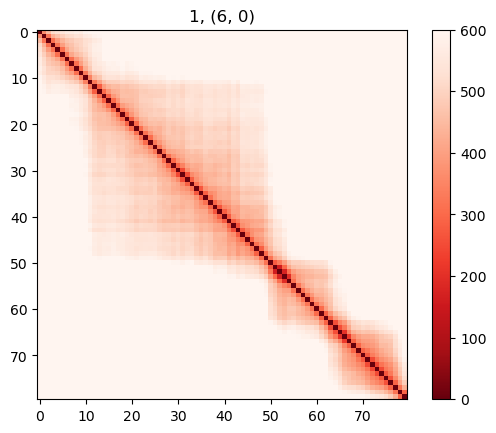

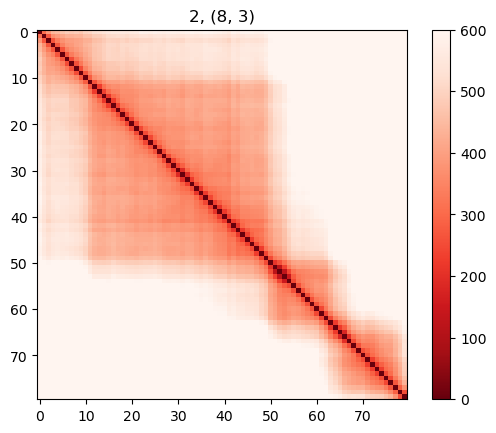

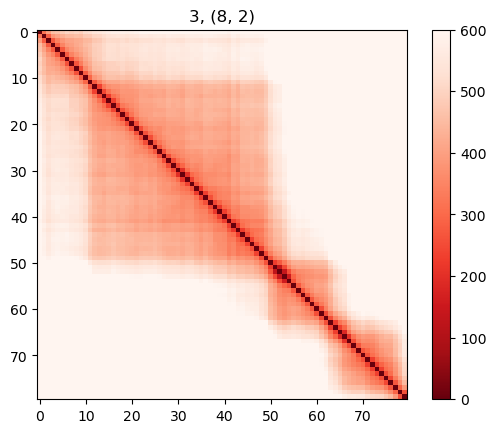

In [52]:
for i in range(3):
    plt.imshow(metastr_dict[bottom_10_indices[i]], cmap='Reds_r', vmax=600)
    plt.colorbar()
    plt.title('{}, {}'.format(i+1, bottom_10_indices[i]))
    plt.savefig(os.path.join(save_dir, 'bottom_{}_metastructure.png'.format(i+1)), dpi=300, bbox_inches='tight')
    plt.show()

In [39]:
plt.imshow(np.log(cnc_weights_grid / esc_weights_grid), cmap='coolwarm', vmin=-3/2, vmax=3/2)
plt.colorbar()
plt.xticks(np.arange(10), [f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()], rotation=45)
plt.yticks(np.arange(10), [f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()][::-1], rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; P_\mathrm{CNC}/P_\mathrm{ESC}$')
plt.savefig(os.path.join(save_dir, 'prob_ratio.png'), dpi=300, bbox_inches='tight')

# Annotate the top 3 highest values
for i in range(1, 4):
    plt.scatter(top_10_indices[-i][1], top_10_indices[-i][0], color='red', s=100, edgecolor='white')
    # plt.text(top_10_indices[-i][0], top_3_coords[-i][1], f'{data[top_3_coords[0][i], top_3_coords[1][i]]:.2f}', 
    #          color='white', ha='center', va='center', fontsize=9, fontweight='bold')
    
for i in range(3):
    plt.scatter(bottom_10_indices[i][1], bottom_10_indices[i][0], color='blue', s=100, edgecolor='white')

plt.savefig(os.path.join(save_dir, 'cnc_esc_prob_ratio_annotate.png'), dpi=300, bbox_inches='tight')

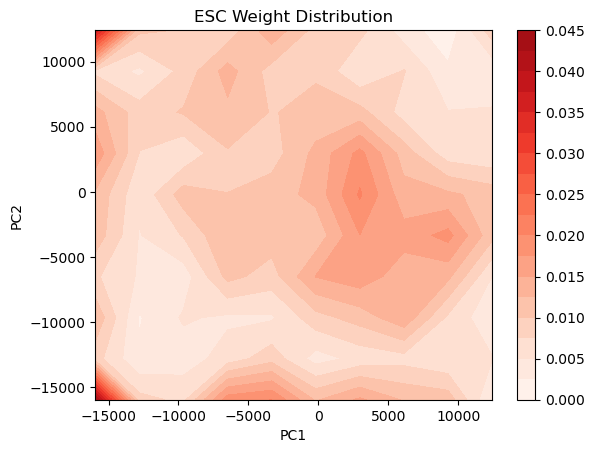

In [54]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.05)
plt.contourf(esc_weights_df['PC1'].unique(), esc_weights_df['PC2'].unique(), 
             esc_weights_df['weight'].values.reshape(10, 10).T,
             norm=norm, levels=20, cmap='Reds')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC Weight Distribution')
plt.savefig(os.path.join(save_dir, 'esc_weight_distribution.png'), dpi=300, bbox_inches='tight')

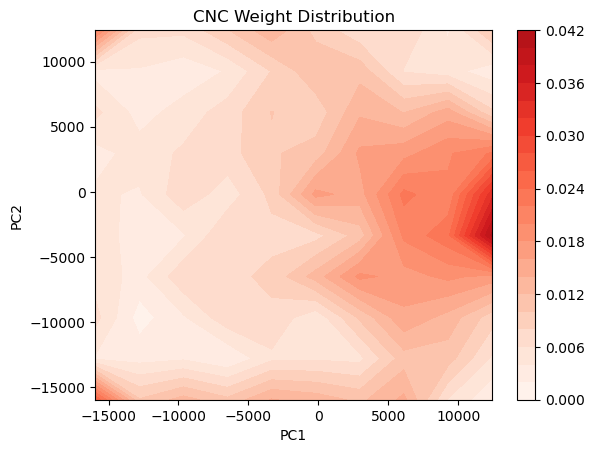

In [55]:
plt.contourf(cnc_weights_df['PC1'].unique(), cnc_weights_df['PC2'].unique(), 
             cnc_weights_df['weight'].values.reshape(10, 10).T,
             norm=norm, levels=20, cmap='Reds')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC Weight Distribution')
plt.savefig(os.path.join(save_dir, 'cnc_weight_distribution.png'), dpi=300, bbox_inches='tight')

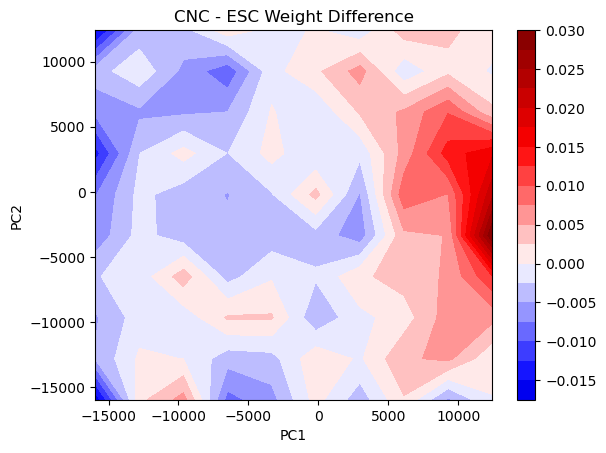

In [84]:
weight_diff = cnc_weights_df['weight'].values.reshape(10, 10).T - esc_weights_df['weight'].values.reshape(10, 10).T
plt.contourf(cnc_weights_df['PC1'].unique(), cnc_weights_df['PC2'].unique(),
                weight_diff, levels=20, cmap='seismic', vmin=-0.03, vmax=0.03)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC - ESC Weight Difference')
plt.savefig(os.path.join(save_dir, 'cnc_esc_weight_difference.png'), dpi=300, bbox_inches='tight')

<Axes: xlabel='PC1', ylabel='PC2'>

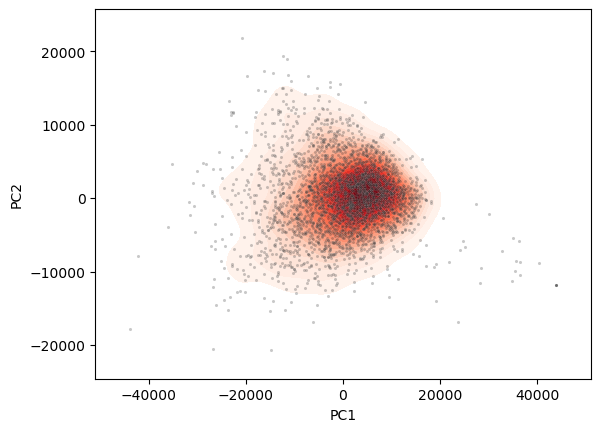

In [80]:
sns.kdeplot(data=all_df, x='PC1', y='PC2', fill=True, levels=20, cmap='Reds')
sns.scatterplot(data=all_df, x='PC1', y='PC2', s=5, color=".15", alpha=0.25)

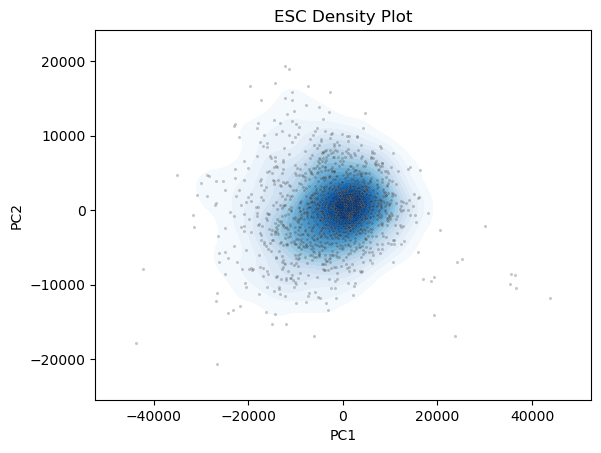

In [95]:
sns.kdeplot(data=esc_df, x='PC1', y='PC2', fill=True, levels=20, cmap='Blues')
sns.scatterplot(data=esc_df, x='PC1', y='PC2', s=5, color=".15", alpha=0.25)
plt.title('ESC Density Plot')
plt.savefig(os.path.join(save_dir, 'esc_distribution.png'), dpi=300, bbox_inches='tight')

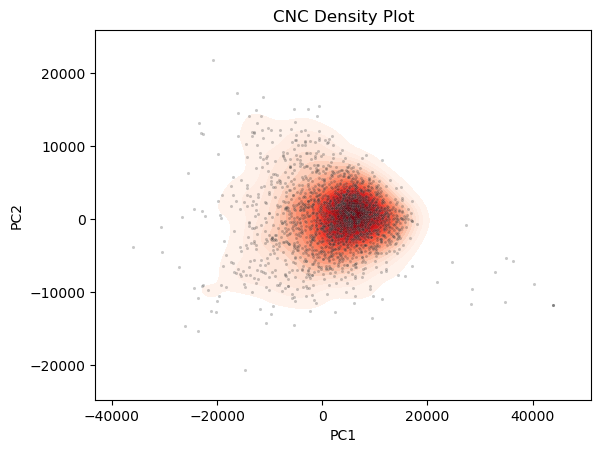

In [82]:
sns.kdeplot(data=cnc_df, x='PC1', y='PC2', fill=True, levels=20, cmap='Reds')
sns.scatterplot(data=cnc_df, x='PC1', y='PC2', s=5, color=".15", alpha=0.25)
plt.title('CNC Density Plot')
plt.savefig(os.path.join(save_dir, 'cnc_distribution.png'), dpi=300, bbox_inches='tight')


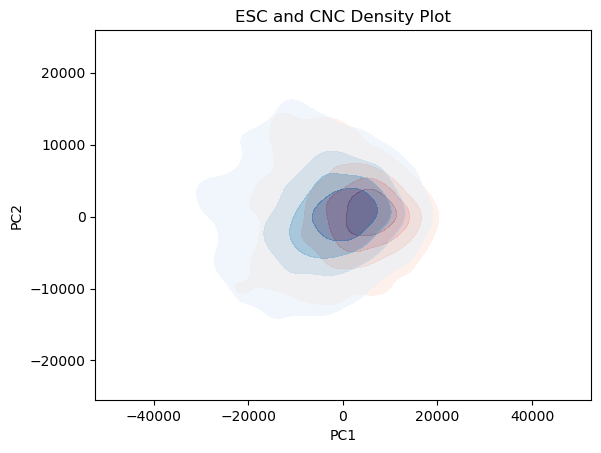

In [94]:
sns.kdeplot(data=cnc_df, x='PC1', y='PC2', fill=True, levels=5, cmap='Reds', alpha=0.5, label='CNC')
sns.kdeplot(data=esc_df, x='PC1', y='PC2', fill=True, levels=5, cmap='Blues', alpha=0.5, label='ESC')
plt.title('ESC and CNC Density Plot')
plt.savefig(os.path.join(save_dir, 'all_distribution.png'), dpi=300, bbox_inches='tight')


In [35]:
cnc_reweight_map = np.zeros(6400,)
esc_reweight_map = np.zeros(6400,)
for i in range(100):
    cnc_reweight_map += cnc_weights[i] * metastr_from_pca[i, :]
    esc_reweight_map += esc_weights[i] * metastr_from_pca[i, :]

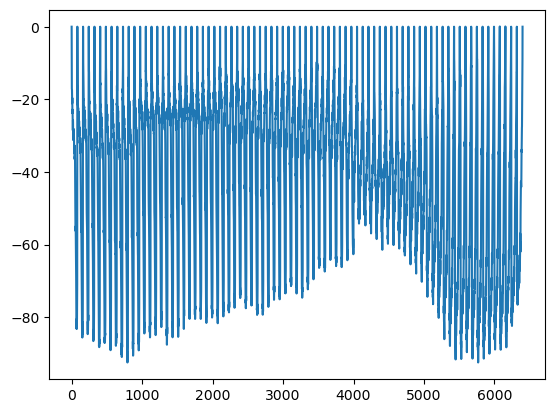

In [36]:
plt.plot(cnc_reweight_map - esc_reweight_map)

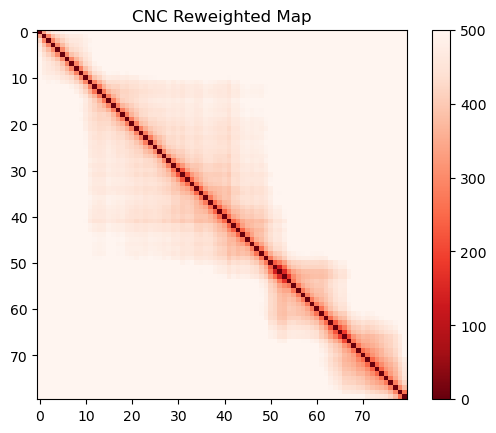

In [50]:
plt.imshow(cnc_reweight_map.reshape(80, -1), cmap='Reds_r', vmax=500)
plt.colorbar()
plt.title('CNC Reweighted Map')
plt.savefig(os.path.join(save_dir, 'cnc_reweight_map.png'), dpi=300, bbox_inches='tight')

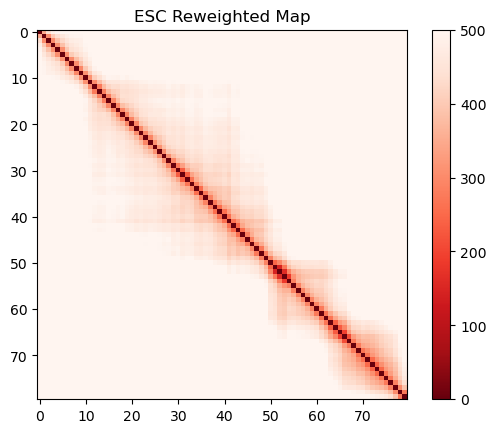

In [51]:
plt.imshow(esc_reweight_map.reshape(80, -1), cmap='Reds_r', vmax=500)
plt.colorbar()
plt.title('ESC Reweighted Map')
plt.savefig(os.path.join(save_dir, 'esc_reweight_map.png'), dpi=300, bbox_inches='tight')

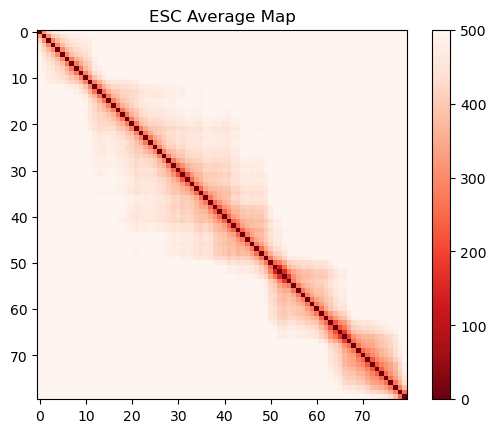

In [46]:
plt.imshow(np.mean(esc_maps_interp, axis=0), cmap='Reds_r', vmax=500)
plt.colorbar()
plt.title('ESC Average Map')
plt.savefig(os.path.join(save_dir, 'esc_average_map.png'), dpi=300, bbox_inches='tight')

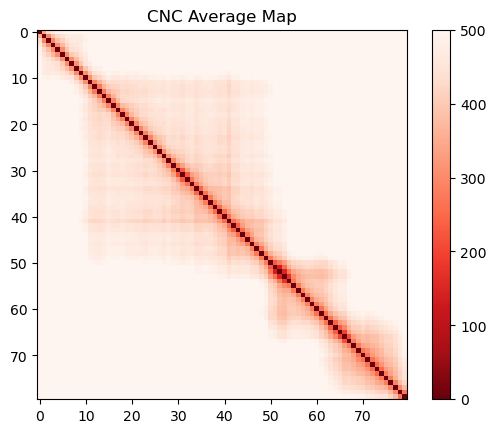

In [45]:
plt.imshow(np.mean(cnc_maps_interp, axis=0), cmap='Reds_r', vmax=500)
plt.colorbar()
plt.title('CNC Average Map')
plt.savefig(os.path.join(save_dir, 'cnc_average_map.png'), dpi=300, bbox_inches='tight')

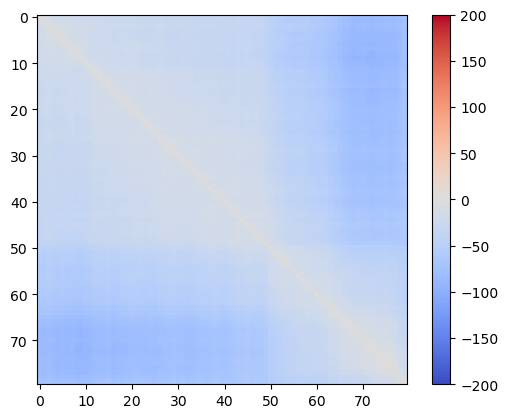

In [91]:
plt.imshow(cnc_reweight_map.reshape(80, 80) - esc_reweight_map.reshape(80, 80), cmap='coolwarm', vmin=-200, vmax=200)
plt.colorbar()

In [98]:
esc_sort_indices = np.argsort(esc_weights)[::-1]
cnc_sort_indices = np.argsort(cnc_weights)[::-1]

In [99]:
esc_sort_indices

array([ 0,  9, 65, 40, 30, 84, 66, 64,  6, 63, 74, 60, 53, 49, 72, 38, 73,
       75,  7, 55, 56, 83, 85, 34, 70, 50,  5,  2, 37,  4, 95, 80, 76, 25,
       44, 45, 62, 67, 94, 54, 33, 57, 19, 27, 35, 47, 29, 36, 58, 59, 52,
       41, 99, 48, 43, 46, 17,  1, 10, 28, 39, 69,  3, 24, 78, 16, 82,  8,
       20, 71, 77, 86, 31, 61, 15, 26, 22, 97, 96, 81, 68, 91, 87, 93, 14,
       13, 42, 32, 18, 51, 79, 21, 23, 92, 98, 88, 11, 12, 90, 89])

In [100]:
cnc_sort_indices

array([94, 95,  0, 84, 75, 96,  9, 74, 85, 86, 63, 83, 76, 93, 73, 55, 66,
       72, 65, 87, 70, 40, 67, 49, 82, 50, 53, 20, 77, 58, 60, 68, 71, 64,
       56, 81, 30, 62, 99, 10, 47, 39, 46, 59, 92, 57, 43, 45, 97, 48, 34,
       79, 23, 42, 25, 32, 44, 33, 54, 36, 37,  2, 19,  7, 29, 69, 26, 80,
       78, 51, 91, 41, 61,  3, 35, 16, 88, 27,  4, 52,  5, 38, 15, 24, 18,
       89,  1, 21, 22, 14, 11,  6,  8, 13, 17, 98, 28, 90, 31, 12])

In [103]:
def jaccard_similarity(set1, set2):
    """
    Calculate the Jaccard similarity between two sets.

    Parameters:
    set1 (set): First set.
    set2 (set): Second set.

    Returns:
    float: Jaccard similarity between set1 and set2.
    """
    set1 = set(set1)
    set2 = set(set2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union


In [101]:
esc_top_40 = esc_sort_indices[:40]
cnc_top_40 = cnc_sort_indices[:40]

In [104]:
jaccard_similarity(esc_top_40, cnc_top_40)

0.5094339622641509

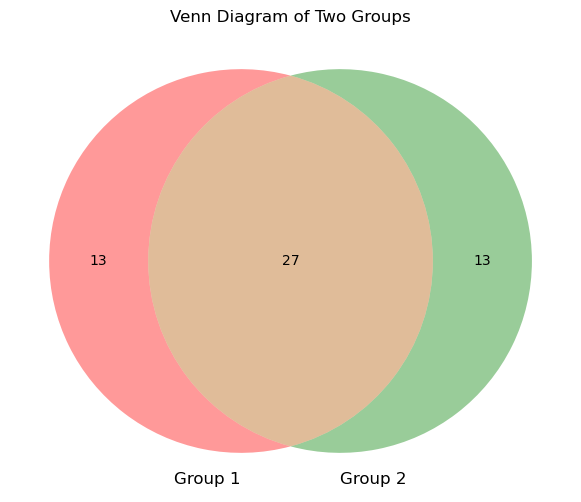

In [106]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Define two sets
set1 = set(esc_top_40)
set2 = set(cnc_top_40)

# Create a Venn diagram
plt.figure(figsize=(8, 6))
venn2([set1, set2], ('Group 1', 'Group 2'))

# Add a title
plt.title('Venn Diagram of Two Groups')

# Show the plot
plt.show()


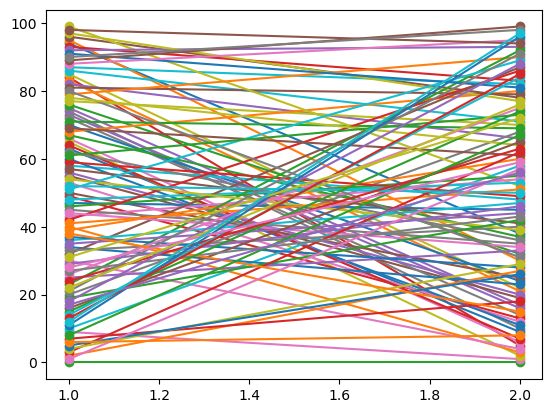

In [98]:
# plot how things change over time
for (x, y) in zip(cnc_sort_indices, esc_sort_indices):
    plt.plot([1, 2], [x, np.where(esc_sort_indices == x)[0][0]], 'o-')

In [26]:
import corner

In [71]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240805/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

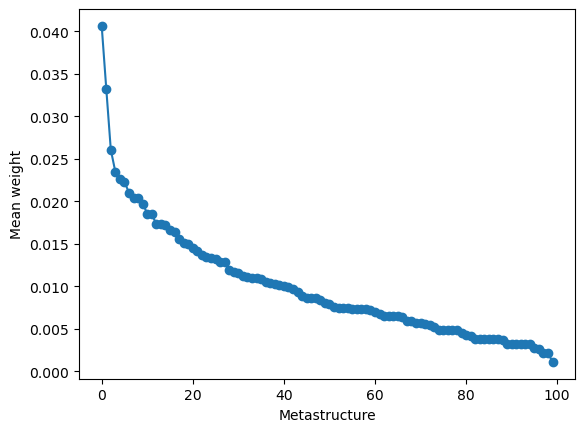

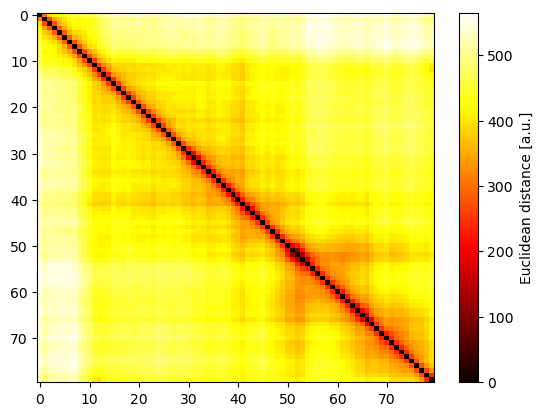

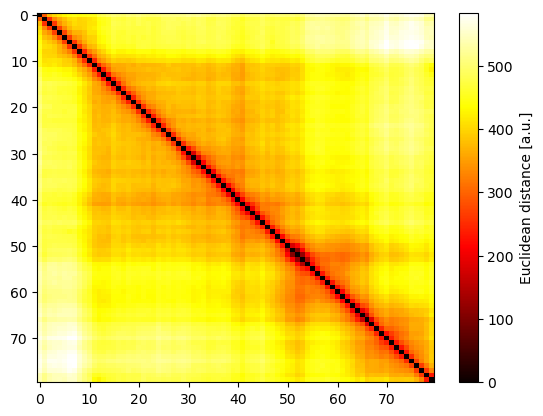

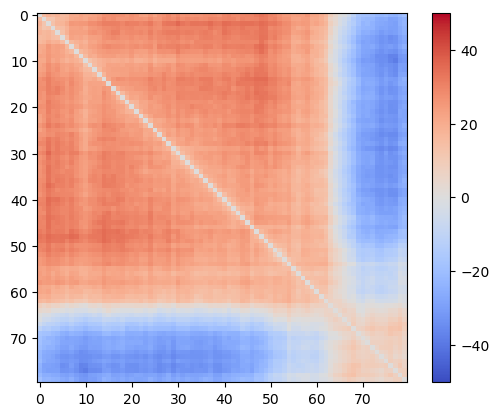

In [72]:
# CNC enriched structures
log_weights_d = np.array(cnc_log_weights)
log_weights_d_flat = log_weights_d.reshape(-1, 100)
# corner.corner(np.exp(log_weights_d_flat), labels=[str(i) for i in range(100)])
# plt.savefig(stan_directory_esc + 'corner_esc.png')
# Add the log weights to the DataFrame
log_weights_df = pd.DataFrame(log_weights_d_flat, columns=[f'M{i}' for i in range(100)])
log_weights_df_meta = log_weights_df.melt(var_name='metastructure', value_name='value')
log_weights_df_meta['value'] = np.exp(log_weights_df_meta['value'])
# sns.displot(
#     log_weights_df_meta, x="value", hue='metastructure', kind='kde', fill=True, common_norm=False
# )
mean_weights = np.mean(np.exp(log_weights_d_flat), axis=0)
sort_indices = np.argsort(mean_weights)[::-1]
plt.plot(np.sort(mean_weights)[::-1], 'o-')
plt.xlabel('Metastructure')
plt.ylabel('Mean weight')
metastr_from_pca_sorted = metastr_from_pca[sort_indices]
# Visualize the most important metastructures
visualize_dmap(metastr_from_pca_sorted[0].reshape(80, -1))
# Visualize the most important metastructures
visualize_dmap(metastr_from_pca_sorted[1].reshape(80, -1))
diff_map = metastr_from_pca_sorted[0].reshape(80, -1) - metastr_from_pca_sorted[1].reshape(80, -1)
plt.imshow(diff_map, cmap='coolwarm', vmin=-50, vmax=50)
plt.colorbar()
M_sorted = np.arange(0, 100)[sort_indices]


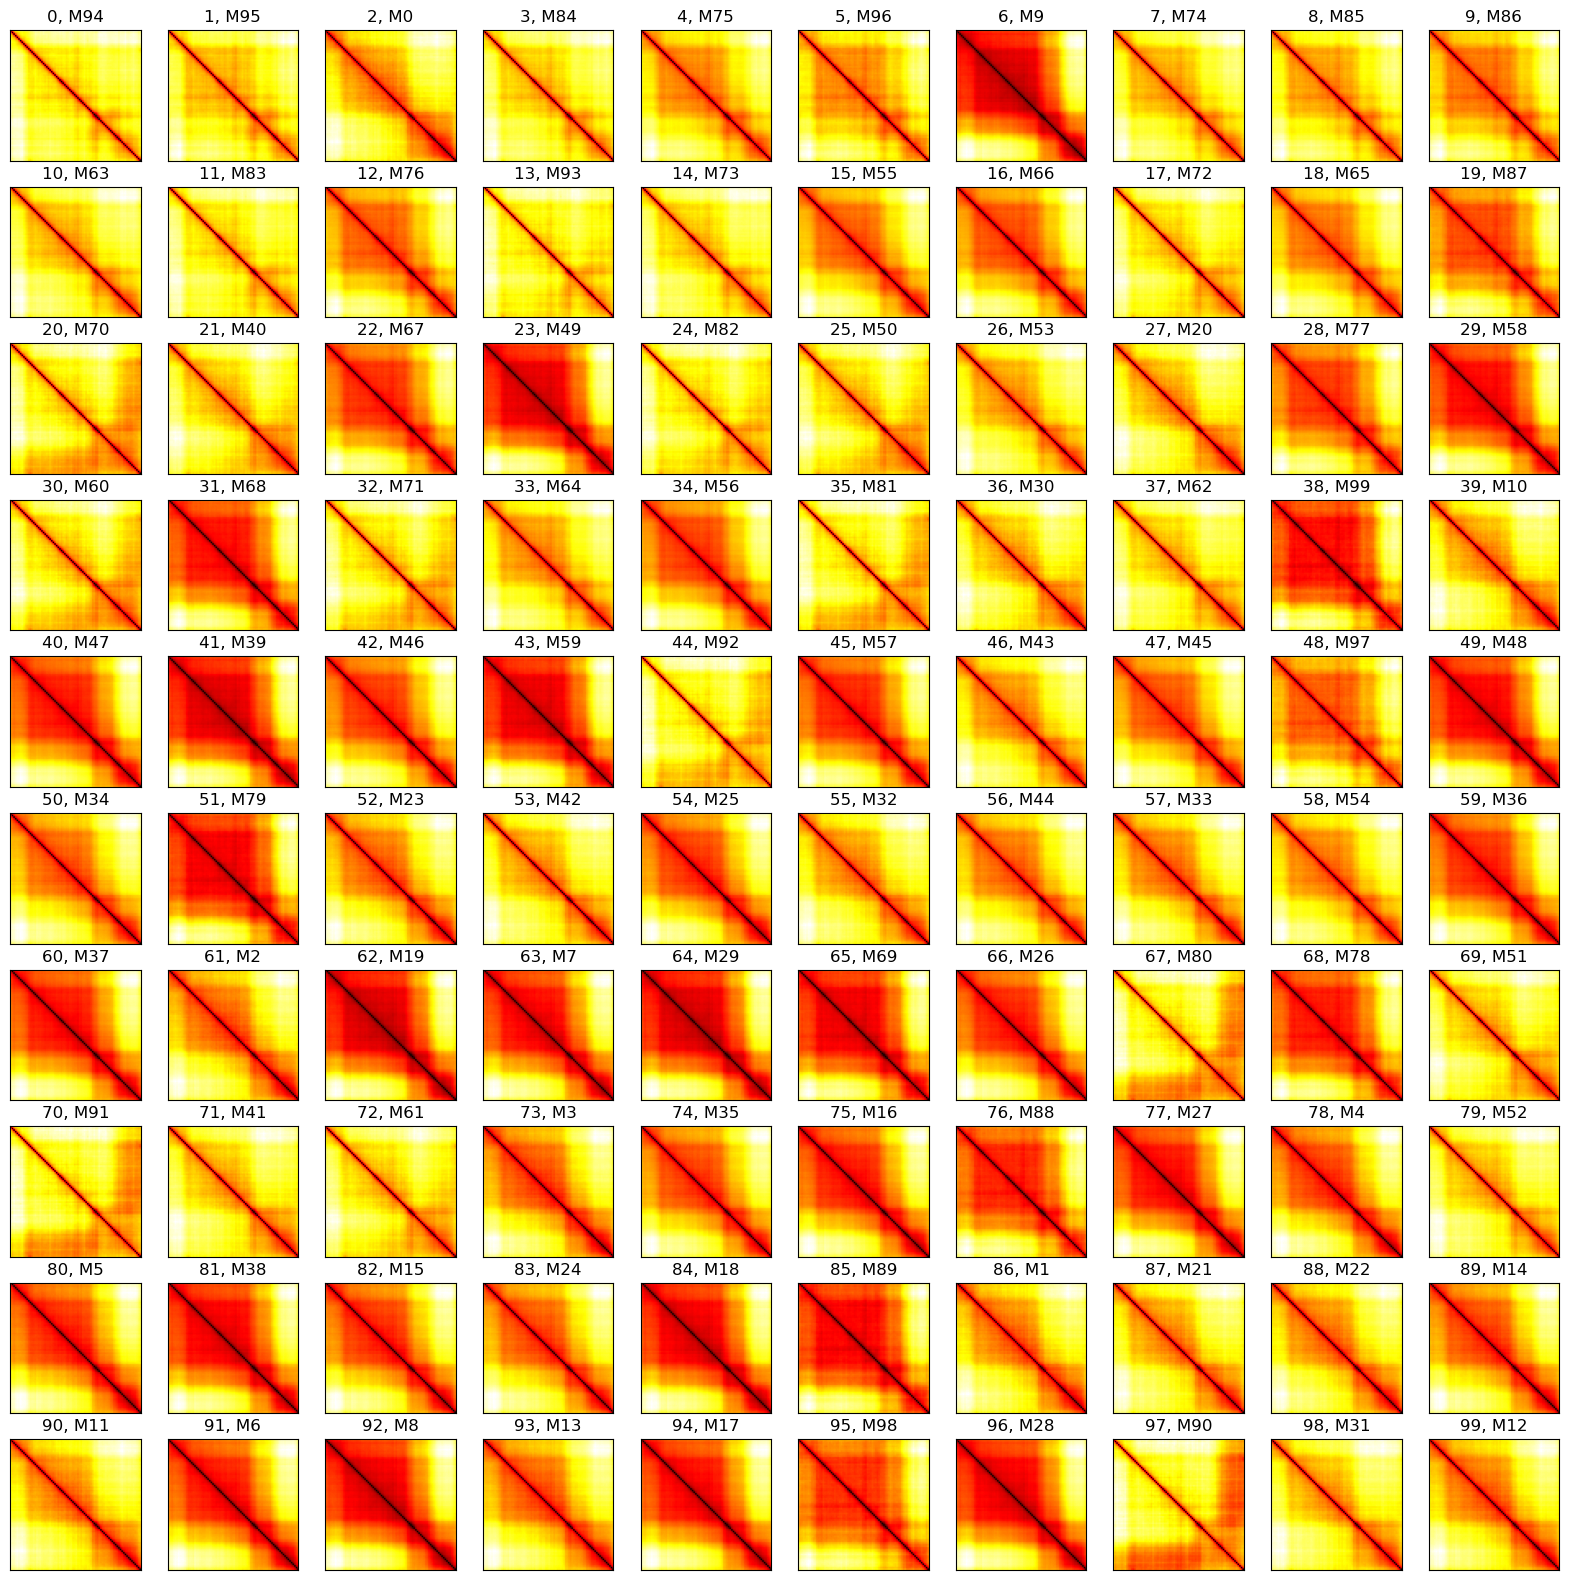

In [73]:

# Plt the metastructure maps sorted by its abundance
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax = ax=axs[i//10, i%10]
    metastr = metastr_from_pca_sorted[i]
    metastr = metastr.reshape((80, 80))
    ax.imshow(metastr, cmap='hot')
    ax.set_title(f'{i}, M{M_sorted[i]}')
        
    # Remove ticks by setting them to an empty list
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig(save_dir + 'metastructure_maps_sorted_by_abundance_cnc.png', dpi=300, bbox_inches='tight')

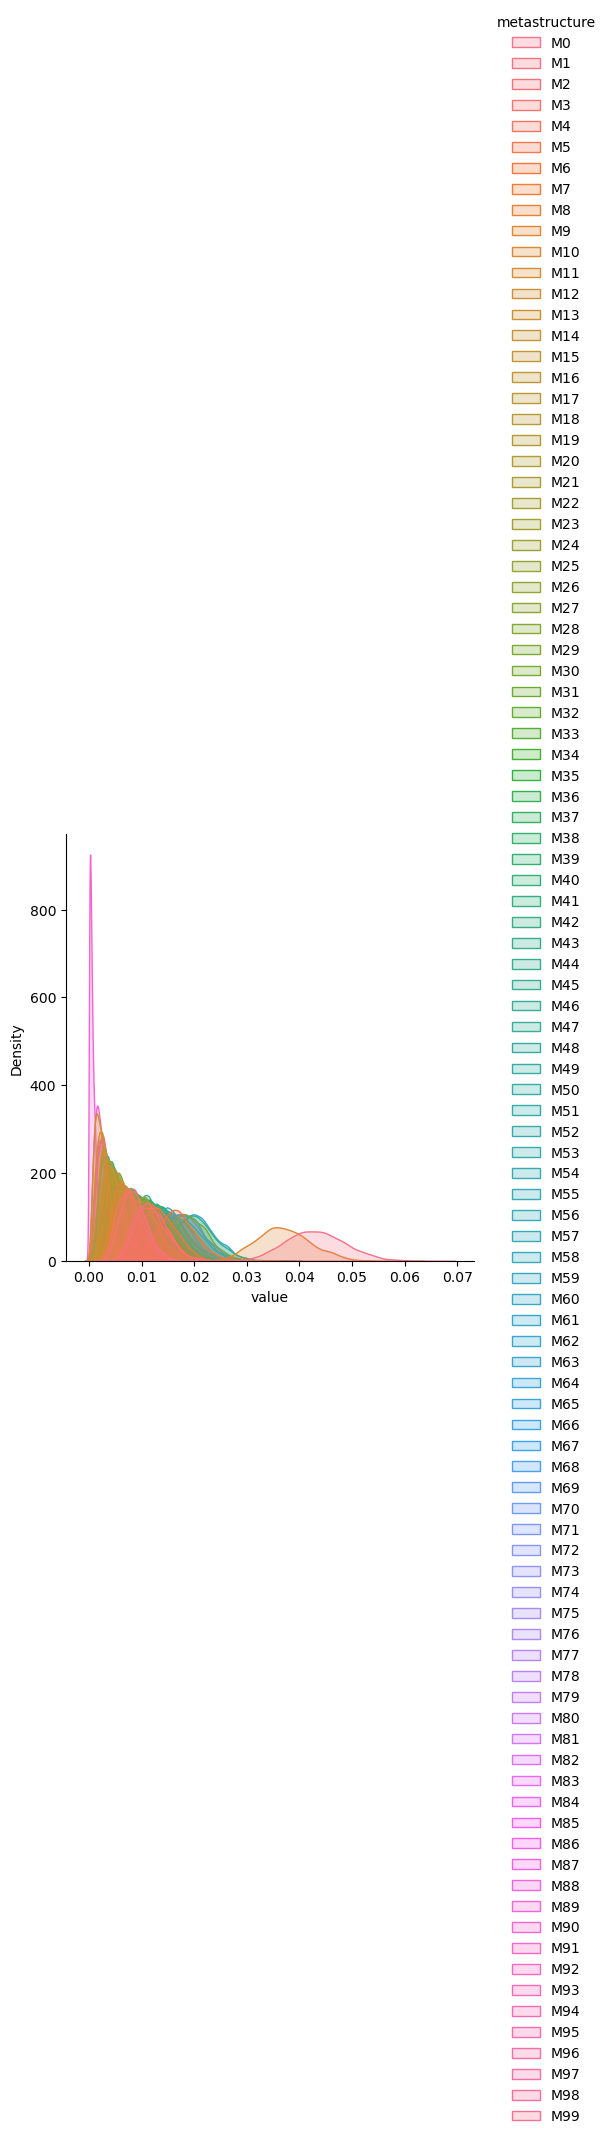

In [74]:
# ESC enriched structures

log_weights_d = np.array(esc_log_weights)
log_weights_d_flat = log_weights_d.reshape(-1, 100)
# corner.corner(np.exp(log_weights_d_flat), labels=[str(i) for i in range(100)])
# plt.savefig(stan_directory_esc + 'corner_esc.png')
log_weights_d_flat.shape
# Add the log weights to the DataFrame
log_weights_df = pd.DataFrame(log_weights_d_flat, columns=[f'M{i}' for i in range(100)])
log_weights_df_meta = log_weights_df.melt(var_name='metastructure', value_name='value')
log_weights_df_meta['value'] = np.exp(log_weights_df_meta['value'])
sns.displot(
    log_weights_df_meta, x="value", hue='metastructure', kind='kde', fill=True, common_norm=False
)
plt.show()


Text(0, 0.5, 'Mean weight')

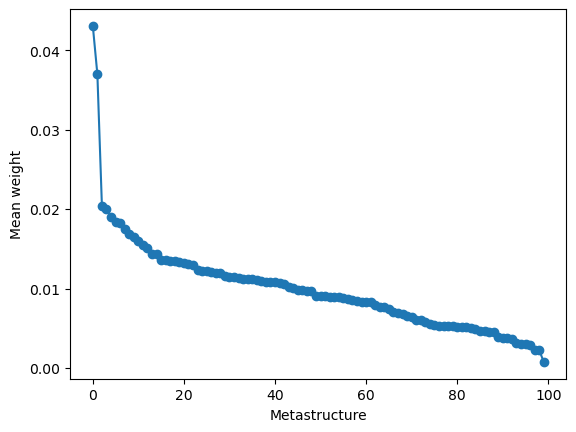

In [75]:
mean_weights = np.mean(np.exp(log_weights_d_flat), axis=0)
sort_indices = np.argsort(mean_weights)[::-1]
plt.plot(np.sort(mean_weights)[::-1], 'o-')
plt.xlabel('Metastructure')
plt.ylabel('Mean weight')


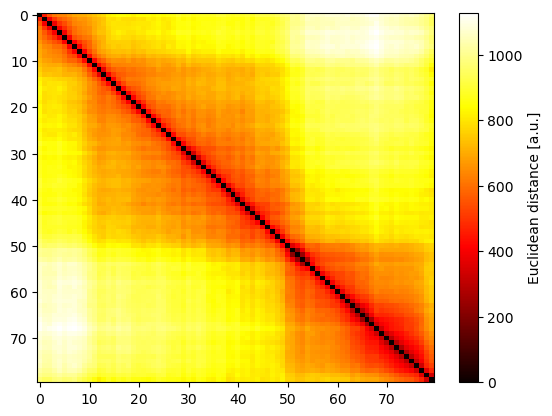

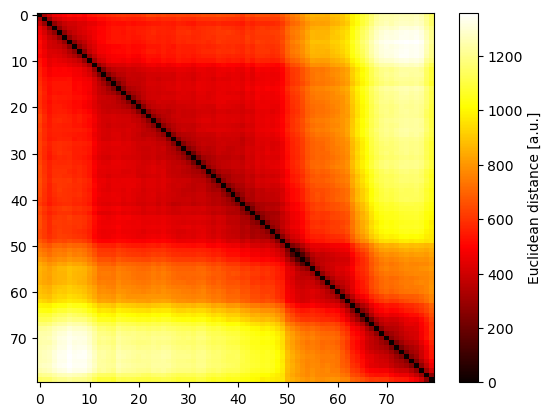

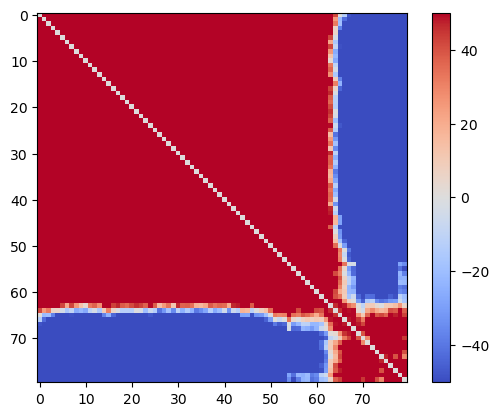

In [76]:
metastr_from_pca_sorted = metastr_from_pca[sort_indices]
# Visualize the most important metastructures
visualize_dmap(metastr_from_pca_sorted[0].reshape(80, -1))
# Visualize the most important metastructures
visualize_dmap(metastr_from_pca_sorted[1].reshape(80, -1))
diff_map = metastr_from_pca_sorted[0].reshape(80, -1) - metastr_from_pca_sorted[1].reshape(80, -1)
plt.imshow(diff_map, cmap='coolwarm', vmin=-50, vmax=50)
plt.colorbar()
M_sorted = np.arange(0, 100)[sort_indices]


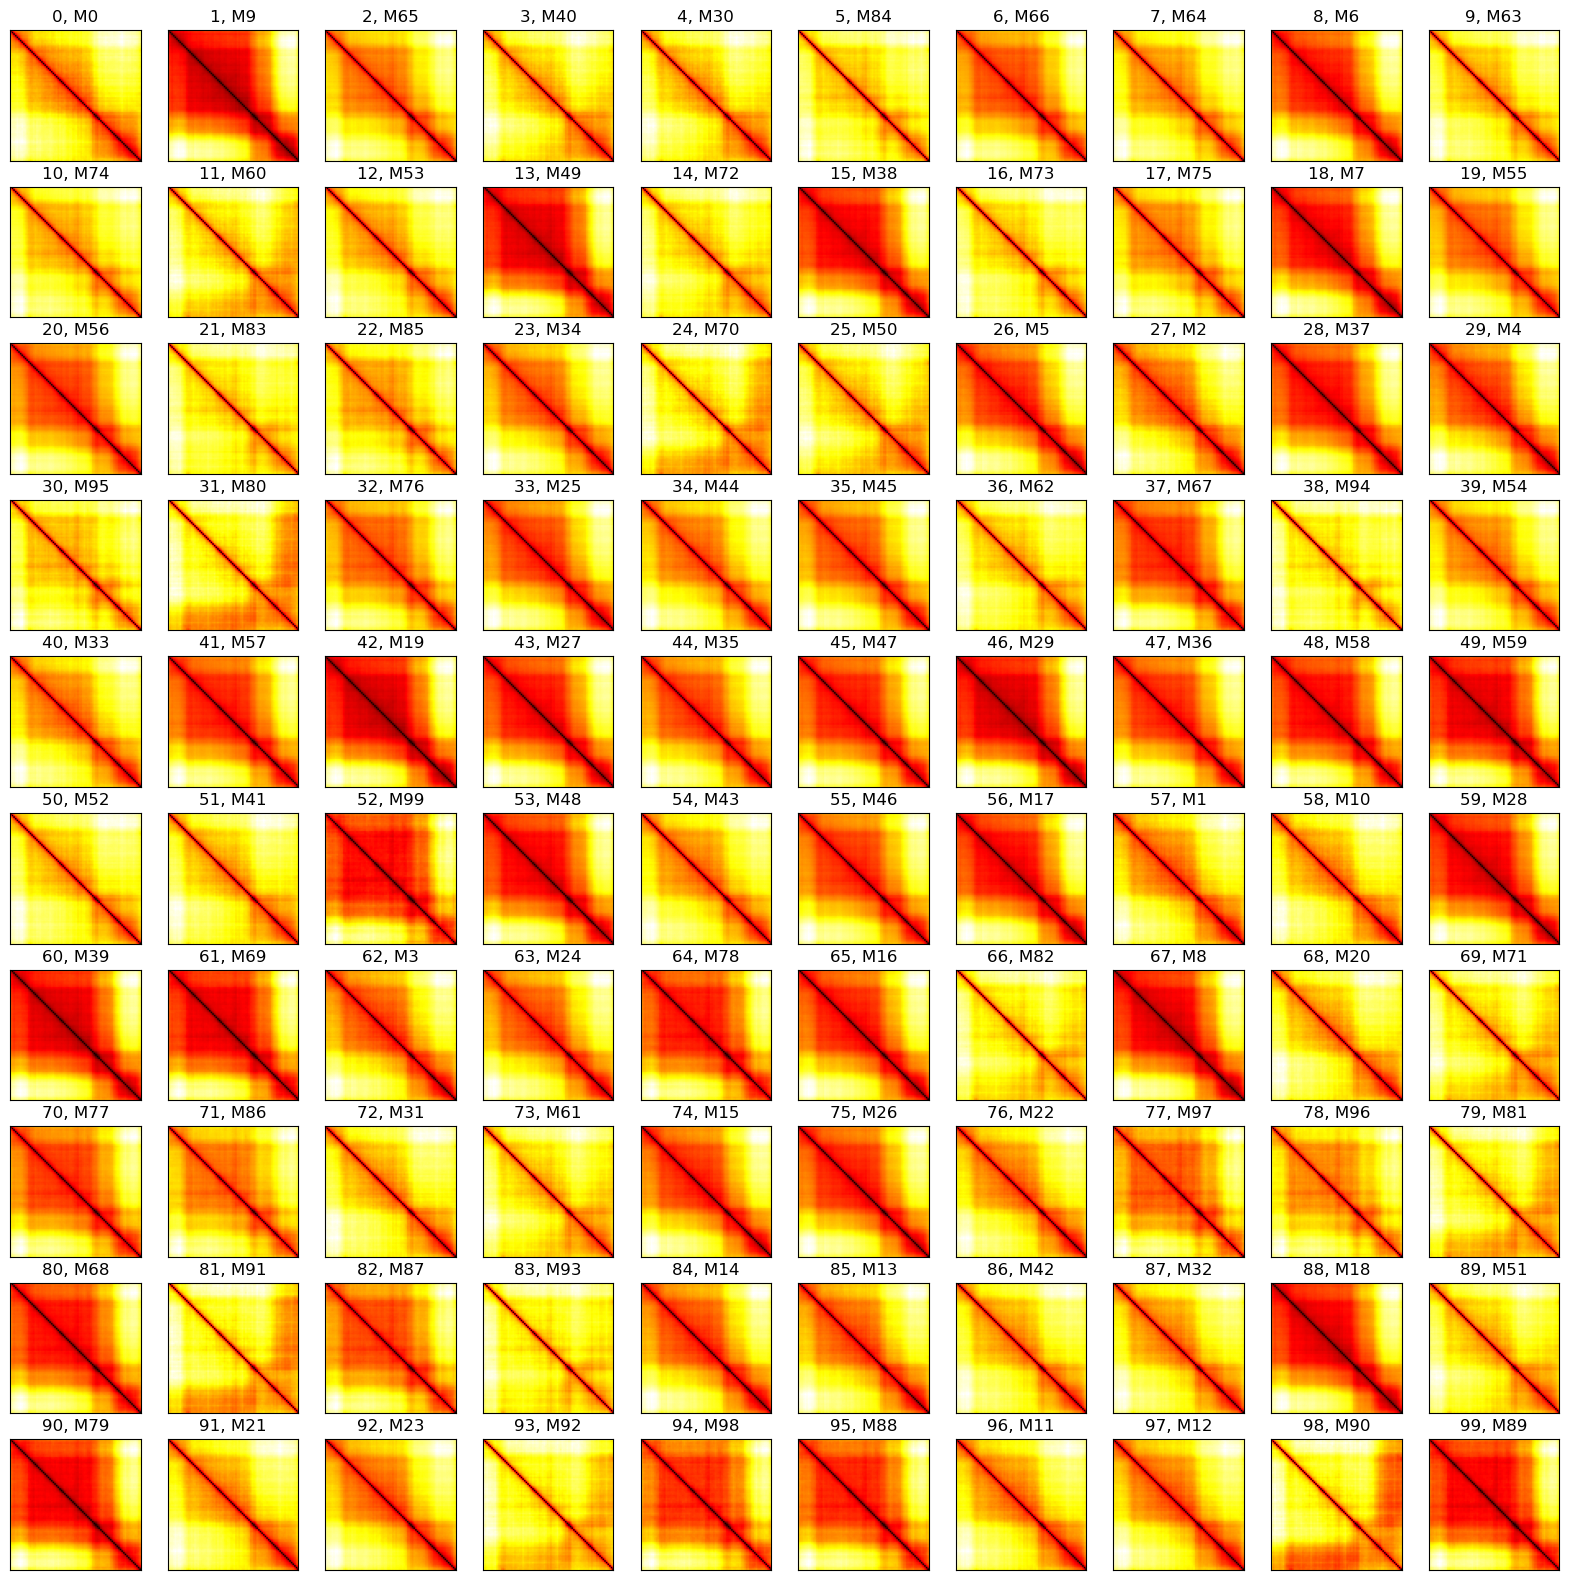

In [77]:
# Plt the metastructure maps sorted by its abundance
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax = ax=axs[i//10, i%10]
    metastr = metastr_from_pca_sorted[i]
    metastr = metastr.reshape((80, 80))
    ax.imshow(metastr, cmap='hot')
    ax.set_title(f'{i}, M{M_sorted[i]}')
        
    # Remove ticks by setting them to an empty list
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig(save_dir + 'metastructure_maps_sorted_by_abundance_esc.png', dpi=300, bbox_inches='tight')